# LaTF training on 2D three hole potential system (T=1.0)
## initial setup

In [ ]:
import numpy as np
import torch
import random
from latf_model import LaTF
from utils import *
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.stats import gaussian_kde

## device test and loading
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"using device: {device}")

## training data loading
traj = np.load("../datasets/three_hole_potential_langevin_temperature_T=1_simulation_traj.npy", allow_pickle=True)
label = np.load("../datasets/three_hole_potential_langevin_temperature_T=1_initial_labels.npy")

## set random seed
seed = 0
random.seed(seed); np.random.seed(seed); torch.manual_seed(seed)

## set lag time Delta t
lag_dt = 30

## set tilted factor tau
tau = 3

## data pre-processing & normalization
traj_mean = np.mean(traj, axis=0); traj_std = np.std(traj, axis=0)
traj_normal = (traj - traj_mean[None, :]) / traj_std[None, :]
past_data = []; future_data = []; labels = []; dataweight = []; beta_temp = []

past_data = traj_normal[:(len(traj_normal)-lag_dt)]
future_data = traj_normal[lag_dt:len(traj_normal)]
labels = label[lag_dt:len(traj_normal)]
dataweight = np.array([1 for i in range(len(past_data))])
temp_weight = np.array([1 for i in range(len(past_data))])

past_data = torch.from_numpy(past_data).float().to(device); future_data = torch.from_numpy(future_data).float().to(device) 
dataweight = torch.from_numpy(dataweight).float().to(device); temp_weight = torch.from_numpy(temp_weight).float().to(device) 
labels = torch.from_numpy(labels).to(device); 
label_data = torch.nn.functional.one_hot(labels.to(torch.int64), num_classes=torch.max(labels.to(torch.int64)+1)).long().to(device) 

# split data into train and validation set
indices = list(range(len(past_data)))
split = int(np.floor(0.2 * len(past_data)))
np.random.shuffle(indices)
train_indices, test_indices = indices[split:], indices[:split]
train_dataset = TimeLaggedDataset(past_data[train_indices], future_data[train_indices], label_data[train_indices], dataweight[train_indices], temp_weight[train_indices])
test_dataset = TimeLaggedDataset(past_data[test_indices], future_data[test_indices], label_data[test_indices], dataweight[test_indices], temp_weight[test_indices])

ib_output_path = './threehole_potential_tilted_prior_tau='+str(tau)+'_dt='+str(lag_dt)+'_results/latf'

latf = LaTF(output_dim=100, data_shape=[2], encoder_type='linear', u_dim=2, lagtime=lag_dt, beta=1e-4,\
            learning_rate=1e-3, lr_scheduler_gamma=0.98,neuron_num1=16, neuron_num2=16, flow_layers=10,\
            flow_neurons=16, flow_split_mask=None, tilted_tau=tau, UpdateLabel=True)

latf.to(device)

latf.fit(train_dataset=train_dataset, test_dataset=test_dataset, batch_size=512, flow_train=False, tolerance=0.001, patience=3, refinements=10,\
            output_path=ib_output_path, beta=1e-4, optimizer='Adam', mask_threshold=0)

torch.save(latf.state_dict(), ib_output_path+'_onestep_spib_seed={}_model.cpt'.format(seed))

latf.fit(train_dataset=train_dataset, test_dataset=test_dataset, batch_size=512, flow_train=True, tolerance=0.01, patience=200, refinements=1,\
            output_path=ib_output_path, beta=1e-4, optimizer='Adam', mask_threshold=0)

torch.save(latf.state_dict(), ib_output_path+'_final_latf_seed={}_model.cpt'.format(seed))

using device: cpu
Update lr to 0.000980
Epoch 1:	Time 2.360641 s
Loss (train) 3.222615	kl loss (train): 1.431129	Reconstruction loss (train) 3.222473
Loss (test) 2.957762	kl loss (test): 2.380749	Reconstruction loss (test) 2.957523
training total loss change=3.222615
State population:
[3.3200953e-02 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 3.3500962e-04 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 8.0002297e-05 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 4.6142951e-01 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 1.1250323e-05 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0

## visualize projected simulation data in IB space

/var/folders/54/rr9b380j0ys7l0r5lqg904pr0000gp/T/ipykernel_42231/3890710706.py:10: RuntimeWarning: divide by zero encountered in log
  RC_G=-np.log(RC_counts)
/var/folders/54/rr9b380j0ys7l0r5lqg904pr0000gp/T/ipykernel_42231/3890710706.py:21: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(_x, _y, RC_G.transpose(),levels=10, colors='black', vmin=0, vmax=6, linewidth=0.5)


(-5.0, 5.0)

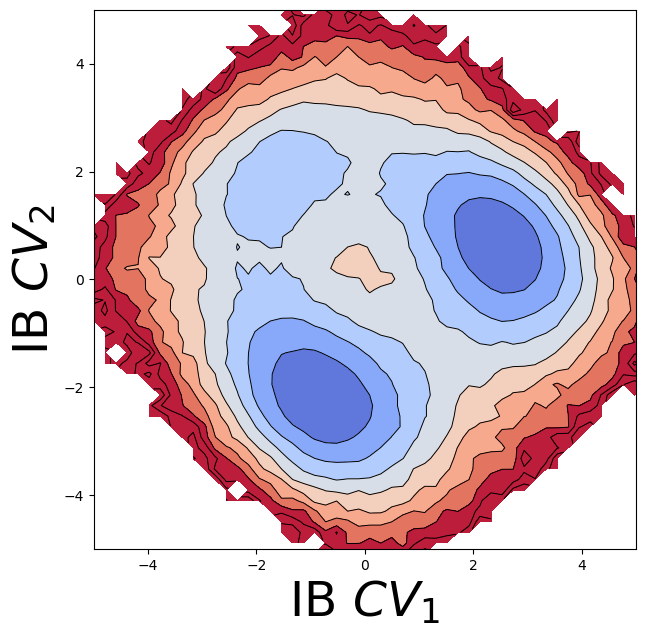

In [8]:
latf.eval()

all_normal_data = torch.from_numpy(traj_normal).float().to(device)
latent_mean, _= latf.encode(all_normal_data); flow_forward, _ = latf.flow(latent_mean); prob = latf.decode(latent_mean)
latent_mean = latent_mean.cpu().detach().numpy(); flow_forward = flow_forward.cpu().detach().numpy(); state_labels = torch.argmax(prob, dim=1).cpu().detach().numpy() 
prob = prob.cpu().detach().numpy()

RC_counts,RC_xbins,RC_ybins = np.histogram2d(latent_mean[:,0],latent_mean[:,1],bins=60)
RC_counts[RC_counts<2]=0
RC_G=-np.log(RC_counts)
RC_G=RC_G-np.nanmin(RC_G)

_x = np.zeros(len(RC_xbins)-1); _y = np.zeros(len(RC_ybins)-1)
for i in range(len(RC_xbins)-1):
    _x[i] = (RC_xbins[i] + RC_xbins[i+1]) / 2
    _y[i] = (RC_ybins[i] + RC_ybins[i+1]) / 2

fig,ax = plt.subplots(1, 1, figsize=(7,7))    
plt.contourf(_x, _y,RC_G.transpose(),levels=10, cmap='coolwarm', vmin=0, vmax=6, alpha=0.9)
plt.rcParams["lines.linewidth"]=0.7
plt.contour(_x, _y, RC_G.transpose(),levels=10, colors='black', vmin=0, vmax=6, linewidth=0.5)
plt.xlabel("IB $CV_{1}$",fontsize=35)
plt.ylabel("IB $CV_{2}$",fontsize=35)
plt.xlim(-5, 5)
plt.ylim(-5, 5)

## visualize flow-transformed density in the prior space

/var/folders/54/rr9b380j0ys7l0r5lqg904pr0000gp/T/ipykernel_42231/2039106927.py:3: RuntimeWarning: divide by zero encountered in log
  RC_G=-np.log(RC_counts)


Text(0, 0.5, 'prior $z_{2}$')

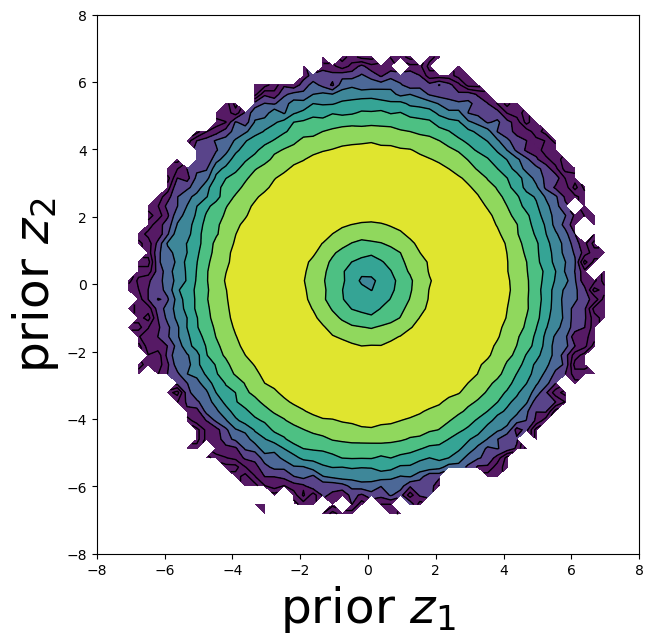

In [3]:
RC_counts,RC_xbins,RC_ybins = np.histogram2d(flow_forward[:,0],flow_forward[:,1],bins=50)
RC_counts[RC_counts<1]=0
RC_G=-np.log(RC_counts)
RC_G=RC_G-np.nanmin(RC_G)

_x = np.zeros(len(RC_xbins)-1); _y = np.zeros(len(RC_ybins)-1)
for i in range(len(RC_xbins)-1):
    _x[i] = (RC_xbins[i] + RC_xbins[i+1]) / 2
    _y[i] = (RC_ybins[i] + RC_ybins[i+1]) / 2

fig,ax = plt.subplots(1, 1, figsize=(7,7))    
plt.contourf(_x, _y,RC_G.transpose(),levels=10, cmap='viridis_r', vmin=0.1, vmax=6, alpha=0.9)
plt.rcParams["lines.linewidth"]=1.0
plt.contour(_x, _y, RC_G.transpose(),levels=10, colors='black', vmin=0.1, vmax=6)
plt.xlim(-8, 8)
plt.ylim(-8, 8)
plt.xlabel("prior $z_{1}$",fontsize=35)
plt.ylabel("prior $z_{2}$",fontsize=35)

Text(0, 0.5, 'prior $z_{2}$')

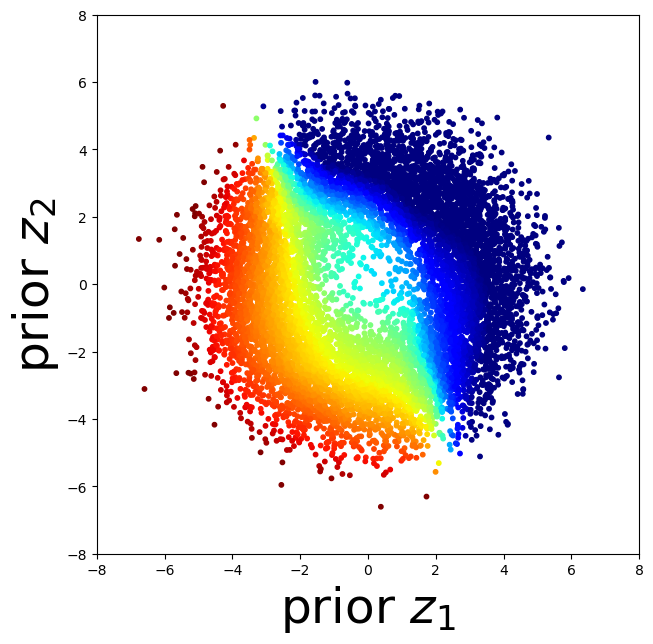

In [4]:
fig,ax = plt.subplots(1, 1, figsize=(7,7))    
plt.scatter(flow_forward[::100, 0], flow_forward[::100, 1], s=10, c=traj[::100, 0], vmin=-1., vmax=1.8, cmap='jet')
plt.xlim(-8, 8)
plt.ylim(-8, 8)
plt.xlabel("prior $z_{1}$",fontsize=35)
plt.ylabel("prior $z_{2}$",fontsize=35)

## visualize LaTF generated latent IB distribution

/var/folders/54/rr9b380j0ys7l0r5lqg904pr0000gp/T/ipykernel_42231/183928814.py:6: RuntimeWarning: divide by zero encountered in log
  RC_G=-np.log(RC_counts)
/var/folders/54/rr9b380j0ys7l0r5lqg904pr0000gp/T/ipykernel_42231/183928814.py:17: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(_x, _y, RC_G.transpose(),levels=10, colors='black', vmin=0, vmax=6, linewidth=0.5)


(-5.0, 5.0)

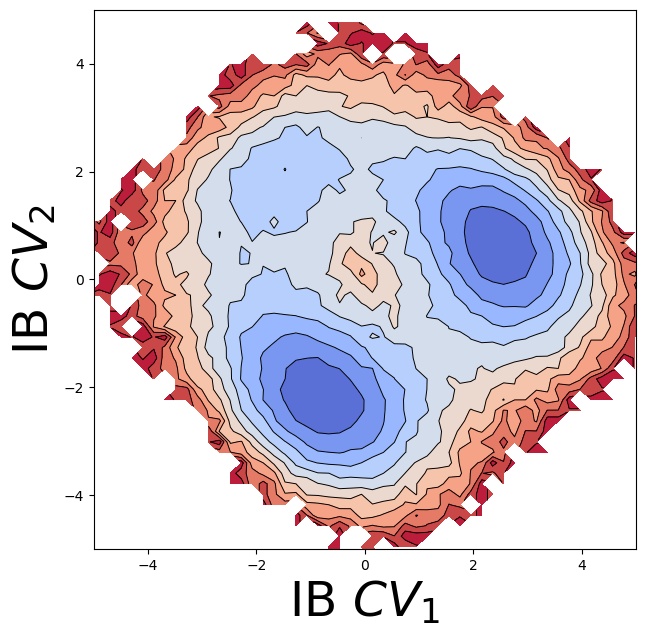

In [9]:
with torch.no_grad():
    samples = generate_sample_from_flow(tau=3, dz=2, temp=1, model=latf, num_samples=int(10000))

RC_counts,RC_xbins,RC_ybins = np.histogram2d(samples[:,0],samples[:,1],bins=70)
RC_counts[RC_counts<2]=0
RC_G=-np.log(RC_counts)
RC_G=RC_G-np.nanmin(RC_G)

_x = np.zeros(len(RC_xbins)-1); _y = np.zeros(len(RC_ybins)-1)
for i in range(len(RC_xbins)-1):
    _x[i] = (RC_xbins[i] + RC_xbins[i+1]) / 2
    _y[i] = (RC_ybins[i] + RC_ybins[i+1]) / 2

fig,ax = plt.subplots(1, 1, figsize=(7,7))    
plt.contourf(_x, _y,RC_G.transpose(),levels=10, cmap='coolwarm', vmin=0, vmax=6, alpha=0.9)
plt.rcParams["lines.linewidth"]=0.7
plt.contour(_x, _y, RC_G.transpose(),levels=10, colors='black', vmin=0, vmax=6, linewidth=0.5)
plt.xlabel("IB $CV_{1}$",fontsize=35)
plt.ylabel("IB $CV_{2}$",fontsize=35)
plt.xlim(-5, 5)
plt.ylim(-5, 5)

(-0.1, 5.0)

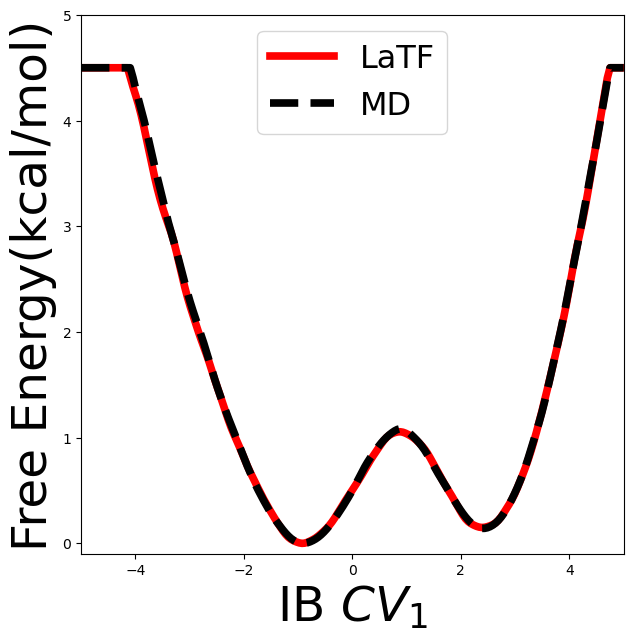

In [10]:
_x1 = -5; _x2 = 5
sample_kde = gaussian_kde(samples[:, 0], bw_method=0.05) 
sample_grid = np.linspace(_x1, _x2, 200)
sample_x = sample_kde(sample_grid)
sample_fe = -np.log(sample_x + 1e-7)
sample_fe=sample_fe-np.min(sample_fe);
sample_fe[sample_fe > 4.5] = 4.5

md_kde = gaussian_kde(latent_mean[:, 0], bw_method=0.05) 
md_grid= np.linspace(_x1, _x2, 200)
md_x = md_kde(md_grid)
md_fe = -np.log(md_x + 1e-7)
md_fe=md_fe-np.min(md_fe);
md_fe[md_fe > 4.5] = 4.5

fig,ax = plt.subplots(1, 1, figsize=(7,7))
plt.plot(sample_grid, sample_fe, linewidth=5.5, color='red', label='LaTF')
plt.plot(md_grid, md_fe, color='black', linewidth=5.5, ls='--', label='MD')
plt.legend(loc='best', fontsize=23)
plt.xlabel("IB $CV_{1}$",fontsize=35)
plt.ylabel('Free Energy(kcal/mol)', fontsize=35)
plt.xlim(_x1, _x2)
plt.ylim(-0.1, 5)

(-0.1, 5.0)

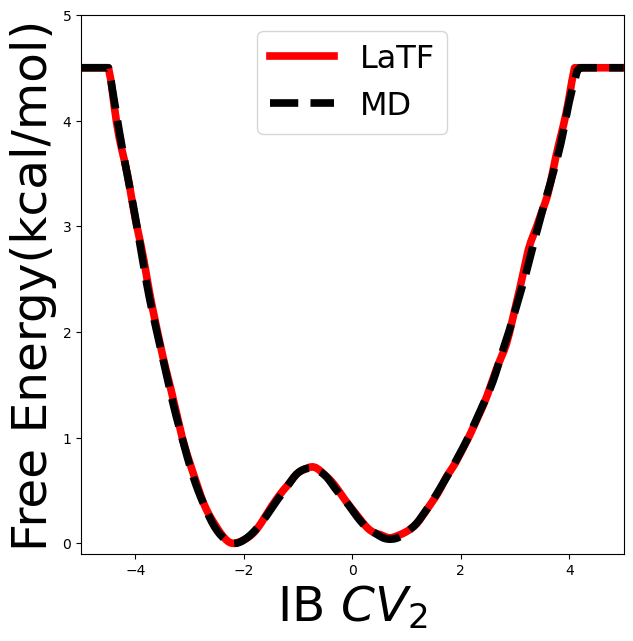

In [11]:
_x1 = -5; _x2 = 5
sample_kde = gaussian_kde(samples[:, 1], bw_method=0.05) 
sample_grid = np.linspace(_x1, _x2, 200)
sample_x = sample_kde(sample_grid)
sample_fe = -np.log(sample_x + 1e-7)
sample_fe=sample_fe-np.min(sample_fe);
sample_fe[sample_fe > 4.5] = 4.5

md_kde = gaussian_kde(latent_mean[:, 1], bw_method=0.05) 
md_grid= np.linspace(_x1, _x2, 200)
md_x = md_kde(md_grid)
md_fe = -np.log(md_x + 1e-7)
md_fe=md_fe-np.min(md_fe);
md_fe[md_fe > 4.5] = 4.5

fig,ax = plt.subplots(1, 1, figsize=(7,7))
plt.plot(sample_grid, sample_fe, linewidth=5.5, color='red', label='LaTF')
plt.plot(md_grid, md_fe, color='black', linewidth=5.5, ls='--', label='MD')
plt.legend(loc='best', fontsize=23)
plt.xlabel("IB $CV_{2}$",fontsize=35)
plt.ylabel('Free Energy(kcal/mol)', fontsize=35)
plt.xlim(_x1, _x2)
plt.ylim(-0.1, 5)